<a href="https://colab.research.google.com/github/BI-DS/ELE-3909/blob/master/lecture6/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.datasets import mnist
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Autoencoder
🔥 Make sure your `Runtime` uses a T4 GPU 🔥

The code below defines the class AutoEncoder with binary crossentropy as loss function. Note that the encoder and decoder are arguments of the class.

In [ ]:
class AutoEncoder(tf.keras.Model):
    def __init__(self, enc, dec, name='autoencoder'):
      super().__init__()
      self.encoder = enc
      self.decoder = dec
      self.cross_entropy = tf.keras.losses.BinaryCrossentropy()

      self.params = encoder.trainable_variables + decoder.trainable_variables

    def call(self, inputs):
      z = self.encoder(inputs)
      x_hat = self.decoder(z)

      self.loss = self.cross_entropy(inputs,x_hat)

    @tf.function
    def train(self,x, optimizer):
        with tf.GradientTape() as tape:
            enc_dec = self.call(x)
        gradients = tape.gradient(self.loss, self.params)
        optimizer.apply_gradients(zip(gradients, self.params))

        return self.loss

    def rep_learning(self, x):
      z = self.encoder(x)

      return z

    def reconstruct(self, x):
      z = self.rep_learning(x)
      x_hat = self.decoder(z)

      return x_hat

I define couple of fuctions that we will use to plot some nice results

In [ ]:
def plot_digits(x_test,decoded_imgs,n):
  plt.figure(figsize=(20, 4))
  for i in range(n):
      # Display original
      ax = plt.subplot(2, n, i + 1)
      plt.imshow(x_test[i].reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # Display reconstruction
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(decoded_imgs[i].reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.show()

def nice_scatter(z_tsne, y_sample, title):
    print('plotting nice scatter...')
    COLORS=[[1.0000, 0,      0     ],
            [0,      1.0000, 0     ],
            [0,      0,      1.0000],
            [1.0000, 0,      1.0000],
            [0.9569, 0.6431, 0.3765],
            [0.4000, 0.8039, 0.6667],
            [0.5529, 0.7137, 0.8039],
            [0.8039, 0.5882, 0.8039],
            [0.7412, 0.7176, 0.4196],
            [0,      0,      0     ]]

    fig, ax = plt.subplots()
    for i, ((x,y),) in enumerate(zip(z_tsne)):
        #rot = random.randint(0,0) # in case you want randomly rotated numbers
        rot = 0
        ax.text(x, y, y_sample[i], color=COLORS[y_sample[i]-1], ha="center", va="center", rotation = rot, fontsize=5)
        ax.plot(x,y, alpha=0.0)
        ax.axis('off')
        plt.title(title)

## Data processing
We use the MNIST dataset, which correspond to images of hand-written digits. It is common to normalize the pixel values (make the values be [0 1]) and for this exercise we convert the data to a vector of size 28*28.

In [ ]:
(x_train, _), (x_test, y_te) = mnist.load_data()
# normalize
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
# vector 28*28
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


11490434/11490434 [==============================] - 0s 0us/step


## Hyperparameters
We need to define some hyperparameters. The `input_shape` of the data refers to the dimensionality of the data, in this case 28*28. The `activation` parameter is the activation function used in the hidden layers. The number of neurons in the hidden layers is given by `units`, and the dimensionality of the latent space is specifed by `z_dim`.

In [ ]:
input_shape = 28*28
activation = 'relu'
units = 400
z_dim = 20

## Encoder and Decoder
Since the data set in this exercise is a vector with 28*28 dimensions, we use fully connected layers for the encoder and decoder. Both with one hidden layer.

In [ ]:
encoder = Sequential([
                    layers.InputLayer(input_shape=input_shape),
                    layers.Dense(units, activation=activation),
                    layers.Dense(z_dim),
                    ])

decoder = Sequential([
                    layers.InputLayer(input_shape=z_dim),
                    layers.Dense(units, activation=activation),
                    layers.Dense(input_shape, activation='sigmoid'),
                    ])

## Model training
We use the `Adam` optimizer to train our autoencoder for 50 epochs

In [ ]:
# create an object
autoencoder = AutoEncoder(encoder,decoder)
# batch size
batch_size = 256
# use tensorflow to create a data hanlder
tr_data  = tf.data.Dataset.from_tensor_slices(x_train).shuffle(x_train.shape[0]).batch(batch_size)
# adam optimizer
optimizer = tf.keras.optimizers.Adam()

In [ ]:
# model training takes 55sec in a T4 GPU
# and 2min37sec  in a Colab CPU
counter = 0
epochs  = 50
start = time.time()
while counter < epochs:
  for i, x_batch in enumerate(tr_data):
    loss = autoencoder.train(x_batch,optimizer)
  counter+=1
  if counter%10==0:
    print('Model has been trained for {} epochs'.format(counter))
print('elapsed time {}'.format(time.time()-start))

Model has been trained for 10 epochs
Model has been trained for 20 epochs
Model has been trained for 30 epochs
Model has been trained for 40 epochs
Model has been trained for 50 epochs
elapsed time 51.1165874004364


## Model inference
After we trained our autoencoder, we can reconstruct some of the images in the test dataset. For this purpose we can use the `reconstruct` method in our autoencoder class. Similarly, we can plot the latent representation of the data using the method `rep_learning`.

✅ First reconstruction

In [ ]:
decoded_imgs = autoencoder.reconstruct(x_test).numpy()

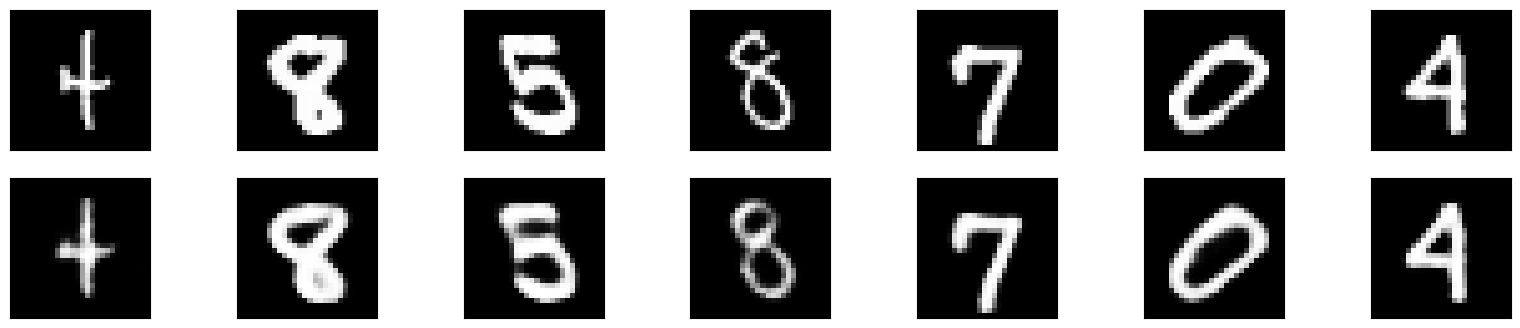

In [ ]:
n = 7  # How many digits we will display
idx = random.sample(range(x_test.shape[0]),n)
plot_digits(x_test[idx],decoded_imgs[idx],n)

The images in the top are real images, while the ones in the bottom are reconstructed images.

✅ Now representation learning ....


plotting nice scatter...


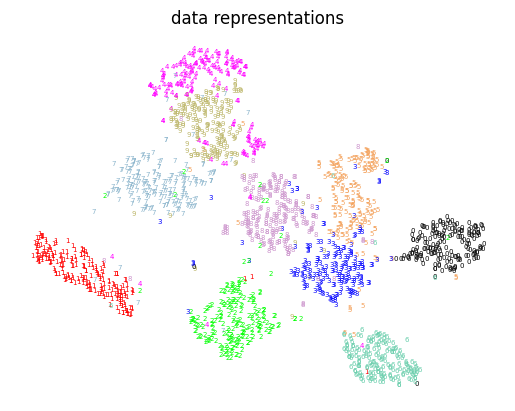

In [ ]:
# I select 2000 images at random, otherwise is too slow...
idx = random.sample(range(x_test.shape[0]),2000)
z = autoencoder.rep_learning(x_test[idx])
# dimensionality reduction
z_2d = TSNE(n_components=2,n_jobs=-1).fit_transform(z)
# plot a nice scatter
nice_scatter(z_2d, y_te[idx],'data representations')

what does this look like?